# Computer vision Lab 2 - Feature extraction

## Edge detection
### Exercise 1
Write a simple program that detects vertical edges in building.png.
#### Assignment 1
Use the Sobel operator to calculate the vertical first-order derivative. Ensure you capture
and visualize the negative filter response values by using appropriate datatypes.

In [1]:
# imports
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the image
image = cv2.imread("./img/building.png", cv2.IMREAD_GRAYSCALE)

# Apply the Sobel operator for vertical edge detection
sobel_vertical = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
sobel_vertical = np.clip(sobel_vertical, 0, 255).astype(np.uint8)

# Save the output image
cv2.imwrite('out/assignment1.png', sobel_vertical)

True

### ![alt text](./out/assignment1.png)

### Exercise 2
Write a simple program to create a DoG filter and detect the edges of the yellow strips in rays.png with it.
#### Assignment 2
Create a 15x15 DoG filter.

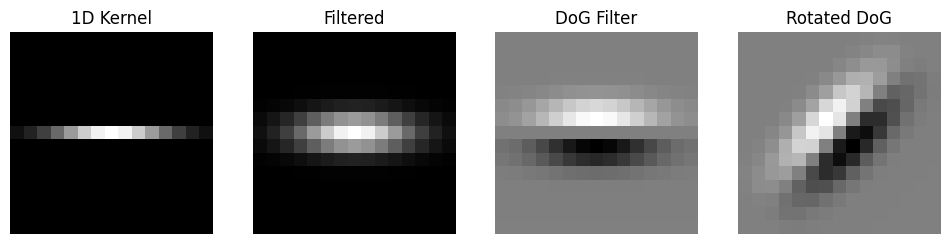

In [3]:
# Function to normalize and save filters
def save_filter(name, f):
    normalized = 0.5 * f / np.max(np.abs(f)) + 0.5  # Normalize to [0, 1]
    cv2.imwrite(f"out/{name}.png", (normalized * 255).astype(np.uint8))

# Create a 1D Gaussian kernel
size = 15
sigma1, sigma2 = 3, 1  # Different standard deviations
gauss_kernel_1d = cv2.getGaussianKernel(size, sigma1).flatten()
gauss_kernel_1d_small = cv2.getGaussianKernel(size, sigma2)

# Create a square matrix and copy the kernel to the middle row
gauss_2d = np.zeros((size, size))
gauss_2d[size // 2, :] = gauss_kernel_1d
save_filter('assignment2-gauss_2d', gauss_2d)

# Filter the square matrix with the smaller Gaussian kernel
gauss_2d_filtered = cv2.filter2D(gauss_2d, -1, gauss_kernel_1d_small)
save_filter('assignment2-filtered', gauss_2d_filtered)

# Compute Difference of Gaussians (DoG) with vertical Sobel
dog_filter = cv2.Sobel(gauss_2d_filtered, cv2.CV_64F, 0, 1, ksize=3)
save_filter('assignment2-DoG_filter', dog_filter)

# Rotate DoG filter by 45 degrees
center = (size // 2, size // 2)
rotation_matrix = cv2.getRotationMatrix2D(center, 45, 1)
rotated_dog_filter = cv2.warpAffine(dog_filter, rotation_matrix, (size, size))
save_filter('assignment2-rotated', rotated_dog_filter)

# Display all filters inline
fig, axes = plt.subplots(1, 4, figsize=(12, 6))
titles = ["1D Kernel", "Filtered", "DoG Filter", "Rotated DoG"]
images = [gauss_2d, gauss_2d_filtered, dog_filter, rotated_dog_filter]

for ax, img, title in zip(axes, images, titles):
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.show()

#### Assignment 3
Filter rays.png with a well chosen DoG filter so that in the resulting image, the edges of the
yellow strips stand out.

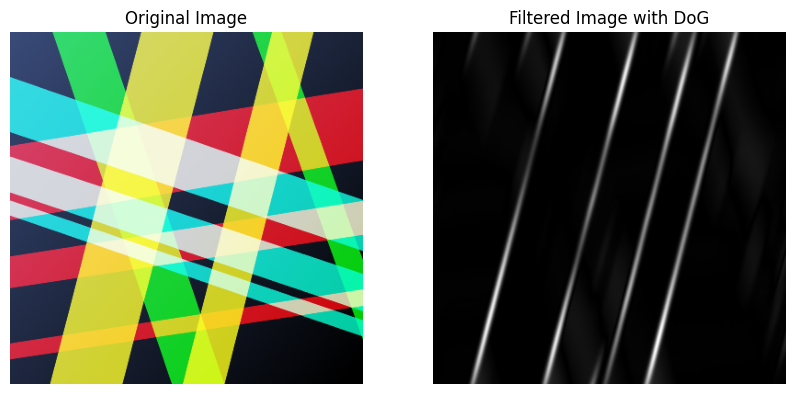

In [4]:
# Load the image
image_path = "img/rays.png"
image = cv2.imread(image_path)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32)

# Define DoG filter size and parameters
size = 120 
sigma1, sigma2 = 30, 2

# Create Gaussian kernels
kernel1 = cv2.getGaussianKernel(size, sigma1).T
kernel2 = cv2.getGaussianKernel(size, sigma2)

dog_filter = np.zeros((size, size))
dog_filter[size // 2] = kernel1

# Compute the Difference of Gaussians (DoG) filter
dog_filter = cv2.filter2D(dog_filter, -1, kernel2)

dog_filter = cv2.Sobel(dog_filter, cv2.CV_64F, 0, 1, ksize=3)

# Create a rotation matrix for better alignment with yellow stripes
rotation_matrix = cv2.getRotationMatrix2D((size // 2, size // 2), 75, 1)
dog_filter_rotated = cv2.warpAffine(dog_filter, rotation_matrix, (size, size))

# Apply DoG filter to the grayscale image
filtered_image = cv2.filter2D(gray, -1, dog_filter_rotated)

# Take absolute value of responses
filtered_image_abs = np.abs(filtered_image)

# Normalize and convert to uint8
filtered_image_norm = cv2.normalize(filtered_image_abs, None, 0, 255, cv2.NORM_MINMAX)
filtered_image_uint8 = filtered_image_norm.astype(np.uint8)

# Save output
cv2.imwrite("out/assignment3.png", filtered_image_uint8)

# Display results
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(filtered_image_uint8, cmap="gray")
plt.title("Filtered Image with DoG")
plt.axis("off")
plt.show()

#### Question 1: What happens when your filter goes "across the border" of the image?
When a filter kernel reaches the image border, it lacks values outside the image to compute the new center value. OpenCV’s `filter2D()` method provides a `BORDER_TYPE` parameter to handle this. The default, `BORDER_REFLECT_101`, mirrors the nearest pixel values to fill in missing areas. Larger kernels create more missing values, which can lead to visible artifacts like stretched or repeated patterns along the edges (see image).  

### Exercise 3
Write a simple program that detects all the edges in rays.png.
#### Assignment 4 
Apply Canny edge detection with thresholds chosen so that the edges of all strips are
detected.

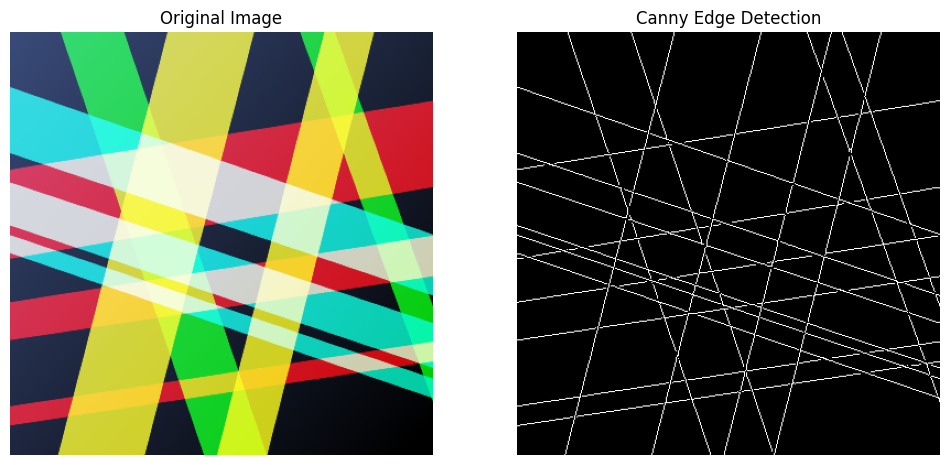

In [5]:
# Load the image
image_path = "img/rays.png"
image = cv2.imread(image_path)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Apply Canny edge detection with optimized thresholds
low_threshold = 5   # Weak edge threshold
high_threshold = 10 # Strong edge threshold
edges = cv2.Canny(gray, low_threshold, high_threshold)

# Save output
cv2.imwrite("out/assignment4.png", edges)

# Display results
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(edges, cmap='gray', vmin=0, vmax=255)  # Fixed vmin/vmax range
axes[1].set_title("Canny Edge Detection")
axes[1].axis('off')

plt.show()

## Line fitting

### Exercise 4
Write a simple program that does Hough line fitting to painting4.jpg.
#### Assignment 5 
Apply Canny edge detection so that you get the four edges of the painting, and as few other
edges as possible. It is inevitable that you find other edges however.


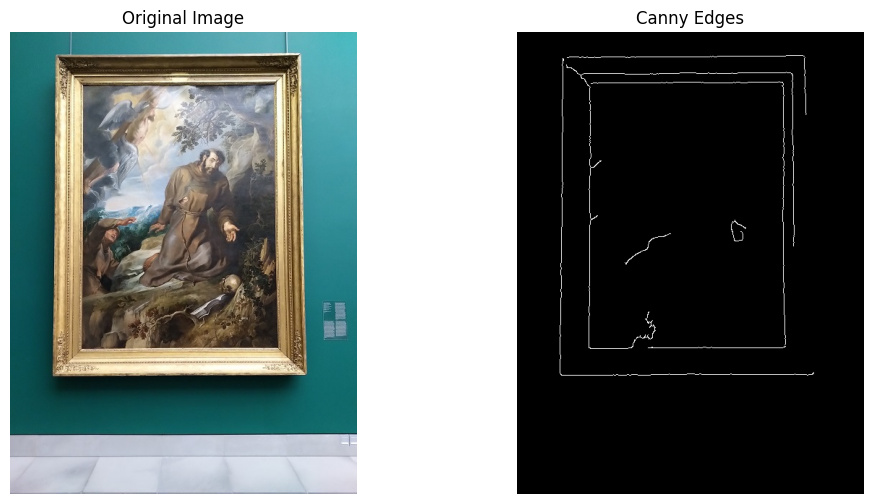

In [6]:
# Load image
image_path = "img/painting4.jpg"
image = cv2.imread(image_path)

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(gray_image, (13, 13), 0)

# Apply Canny edge detection
edges = cv2.Canny(blurred, threshold1=60, threshold2=220)

# Save output
cv2.imwrite("out/assignment5.png", edges)

# Display the original image and the Canny edges
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(edges, cmap='gray')
plt.title("Canny Edges")
plt.axis('off')
plt.show()

#### Assignment 6 
Apply HoughLines to the result of Assignment 5 and visualize the lines on the original
image (use the line function). It is normal too get too many lines, since you cannot get the Canny result
perfect.

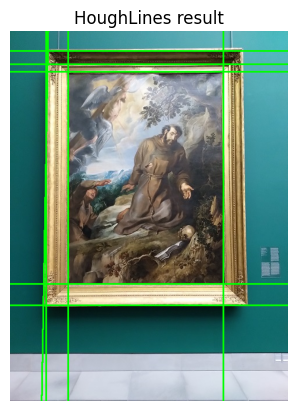

In [7]:
# Detect straight lines using standard Hough Transform
lines = cv2.HoughLines(edges, rho=1, theta=np.pi/180, threshold=120)

# Draw detected lines on the image
frame_lines = image.copy()
if lines is not None:
    for rho, theta in lines[:, 0]:
        # Convert (rho, theta) to Cartesian coordinates
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho

        # Extend the line across the whole image
        x1 = int(x0 + 1000 * (-b))  # Large extension factor
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))

        # Filter only horizontal or vertical lines
        angle = theta * 180 / np.pi
        if abs(angle) < 10 or abs(angle - 90) < 10:  # Horizontal or vertical
            cv2.line(frame_lines, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
# Save output
cv2.imwrite("out/assignment6.png", frame_lines)
            
plt.imshow(cv2.cvtColor(frame_lines, cv2.COLOR_BGR2RGB))
plt.title('HoughLines result')
plt.axis('off')

plt.show()

## Corner detection

### Exercise 5
Write a simple program that detects corners in two images. Try to match the corners across the images.
#### Assignment 7 
Detect Harris corners in shot1.png and shot2.png and visualize them side by side.

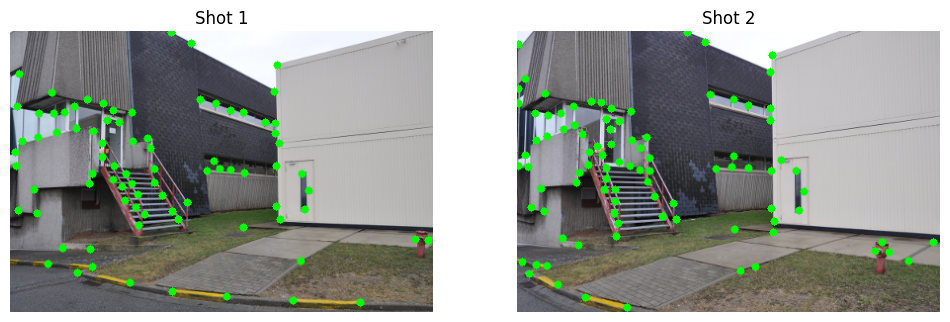

In [8]:
# Load images and convert to grayscale
shot1 = cv2.imread("img/shot1.png")
shot2 = cv2.imread("img/shot2.png")
shot1_gray = cv2.cvtColor(shot1, cv2.COLOR_BGR2GRAY)
shot2_gray = cv2.cvtColor(shot2, cv2.COLOR_BGR2GRAY)

max_corners = 100  
quality_level = 0.01 
min_distance = 10  # Prevent closely packed corners
block_size = 5  # Size of the area to consider for corner detection
use_harris_detector = True

# Detect corners using goodFeaturesToTrack
corners1 = cv2.goodFeaturesToTrack(shot1_gray, max_corners, quality_level, min_distance, blockSize=block_size, useHarrisDetector=use_harris_detector)
corners2 = cv2.goodFeaturesToTrack(shot2_gray, max_corners, quality_level, min_distance, blockSize=block_size, useHarrisDetector=use_harris_detector)
corners1 = corners1.astype(int)
corners2 = corners2.astype(int)

# Draw circles around detected corners
for corner in corners1:
    x, y = corner.ravel()
    cv2.circle(shot1, (x, y), 4, (0, 255, 0), -1)  # Green corners
for corner in corners2:
    x, y = corner.ravel()
    cv2.circle(shot2, (x, y), 4, (0, 255, 0), -1)  

# Save output
cv2.imwrite("out/assignment7-shot1.png", shot1)
cv2.imwrite("out/assignment7-shot2.png", shot2)
    
# Display results
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(cv2.cvtColor(shot1, cv2.COLOR_BGR2RGB))
axes[0].set_title('Shot 1')
axes[0].axis('off')
axes[1].imshow(cv2.cvtColor(shot2, cv2.COLOR_BGR2RGB))
axes[1].set_title('Shot 2')
axes[1].axis('off')
plt.show()

#### Question 2 Name two kinds of problems you foresee in trying to match these corners.

1. **Depth Misinterpretation:**
The algorithm detects corners based on pixel values, not real-world depth. For example, false corners might be detected because of overlapping buildings. The algorithm mistakenly sees two separate buildings as one due to perspective.

2. **Lighting and Viewpoint Variations:**
Changes in lighting conditions (e.g., shadows, highlights) can create high-contrast areas that the algorithm may misinterpret as corners. For instance, a shadow edge in one image might not appear in another due to different lighting, causing inconsistent corner detection. Additionally, changes in camera viewpoint can reveal or hide corners, making it difficult to reliably match them across images. For example, a corner visible in one image might be occluded or appear differently in another due to perspective changes.

#### Assignment 8 
Detect ORB features in each of the two original images, calculate the ORB descriptors for
them, and match the descriptors between the two images. Visualize the 32 best matches.

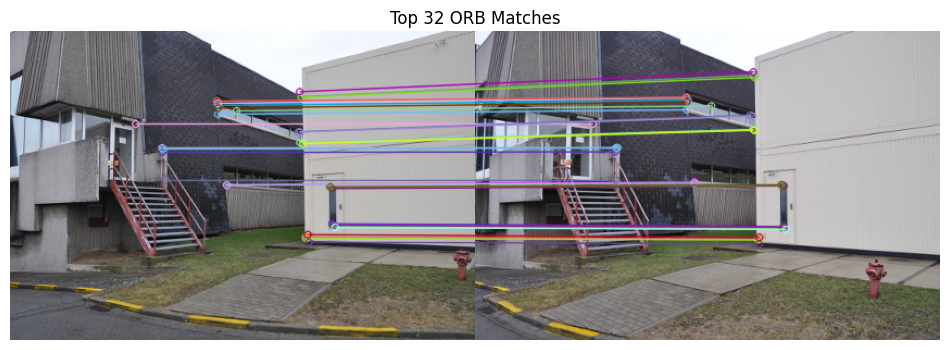

In [9]:
# Load images and convert to grayscale
shot1 = cv2.imread("img/shot1.png")
shot2 = cv2.imread("img/shot2.png")

# Initialize ORB detector (with chosen parameters)
orb = cv2.ORB_create()

# Detect keypoints and compute descriptors
keypoints1, descriptors1 = orb.detectAndCompute(shot1, None)
keypoints2, descriptors2 = orb.detectAndCompute(shot2, None)

# Create a BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors
matches = bf.match(descriptors1, descriptors2)

# Sort matches by distance (best matches first)
matches = sorted(matches, key=lambda x: x.distance)

# Draw the top 32 matches
matched_img = cv2.drawMatches(shot1, keypoints1, shot2, keypoints2, matches[:32], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
matching_result = cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB)

# Save output
cv2.imwrite("out/assignment8.png", matching_result)

# Display the result
plt.figure(figsize=(12, 6))
plt.imshow(matching_result)
plt.title('Top 32 ORB Matches')
plt.axis('off')
plt.show()